<a href="https://colab.research.google.com/github/levhojoyan/Sirius2021/blob/main/NeuralWithWeights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np 
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torch import distributions as distrs


from sklearn.datasets import load_boston
from tqdm.notebook import tqdm

from IPython.display import clear_output

%matplotlib inline

Создадим искусственные данные для задачи регрессии: синус + нормальный шум


In [2]:
# Красиво рисует двумерное распределение
def plot_2d_dots(dots, color='blue', label='None'):
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.scatter(dots[:, 0], dots[:, 1], s=1, c=color, label=label)

In [3]:
sample_size = 100
x_s = torch.empty(sample_size).normal_(mean=0,std=1)
noise_s = torch.empty(sample_size).normal_(mean=0,std=1)

f_s = torch.sin(x_s) # + noise_s 

sample_2d = torch.cat((x_s.unsqueeze(1), f_s.unsqueeze(1)), 1)

print(sample_2d.shape)

torch.Size([100, 2])


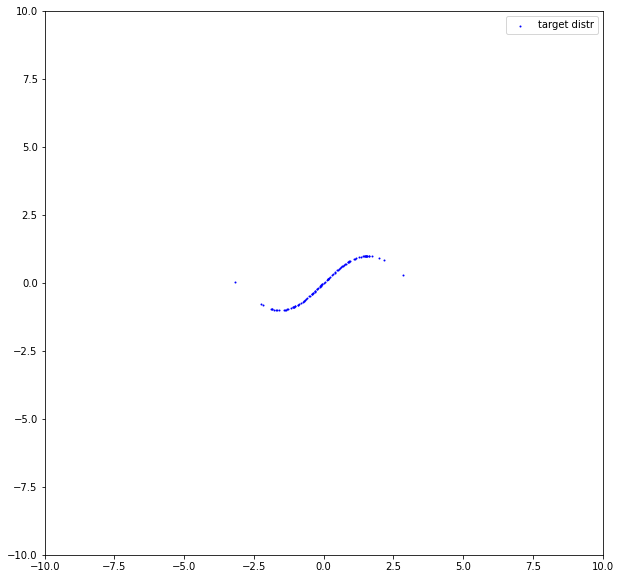

In [4]:
plt.figure(figsize=(10, 10))
plot_2d_dots(sample_2d, label='target distr')
plt.legend()
plt.show()

In [5]:
class RandomDataset(torch.utils.data.Dataset):
    """Our random dataset"""
    
    def __init__(self, x, y):
        self.x, self.y = x, y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return {'sample': torch.tensor(self.x[idx,:], dtype=torch.float), 'target': self.y[idx]}

In [6]:
our_dataset = RandomDataset(sample_2d[:, 0].unsqueeze(1), sample_2d[:, 1])

In [7]:
our_dataset.__getitem__(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


{'sample': tensor([-0.4222]), 'target': tensor(-0.4098)}

In [8]:
sample_2d[1]


tensor([-0.4222, -0.4098])

In [9]:
batch_size=4

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Linear(1, 5) # the simpliest
        self.conv2 = nn.Linear(5, 1)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      return self.conv2(x)

In [11]:
def mse(y_true, y_pred):
  return torch.sum((y_pred - batch_y)**2)

In [12]:
dataloader = torch.utils.data.DataLoader(our_dataset, batch_size=4)
train_size = int(sample_size * 0.7)
test_size = sample_size - train_size

In [13]:
for batch in dataloader:
    batch_x = batch['sample']
    batch_y = batch['target']
    break
print('Sample:', batch_x)
print('Target:', batch_y)

model = Model()
print(batch_x.shape)
y_pred = model(batch_x) # получили предсказания модели
loss = mse(batch_y, y_pred)
print(loss.data, y_pred)

Sample: tensor([[ 1.1223],
        [-0.4222],
        [ 0.8768],
        [-0.5009]])
Target: tensor([ 0.9011, -0.4098,  0.7687, -0.4802])
torch.Size([4, 1])
tensor(8.6646) tensor([[0.6736],
        [0.4221],
        [0.6298],
        [0.4116]], grad_fn=<AddmmBackward>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [19]:
model.parameters

<bound method Module.parameters of Model(
  (conv1): Linear(in_features=1, out_features=5, bias=True)
  (conv2): Linear(in_features=5, out_features=1, bias=True)
)>

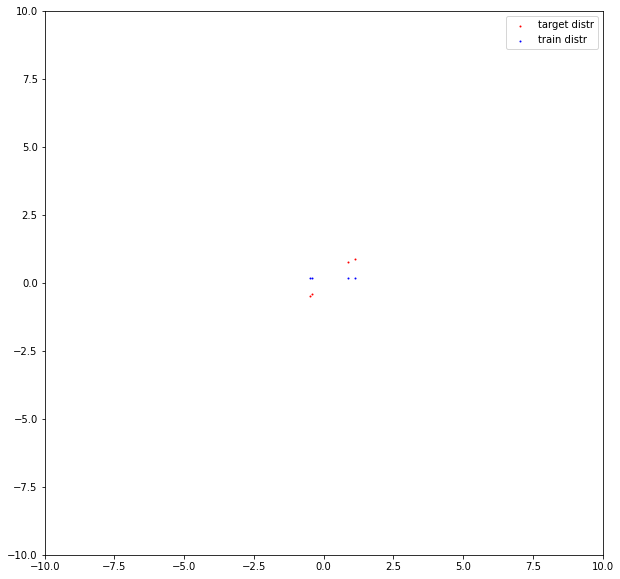

In [50]:
i = 0
for x_train, y_train in tqdm(dataloader): # берем батч из трейн лоадера
    x_train = batch['sample']
    y_train = batch['target']

    print(x_train)
    y_pred = model(x_train) # делаем предсказания
    loss = torch.nn.MSELoss()(y_pred, y_train) # считаем лосс
    loss.backward() # считаем градиенты обратным проходом
    optimizer.step() # обновляем параметры сети
    optimizer.zero_grad() # обнуляем посчитанные градиенты параметров
    i += 1

    if i % 5 == 0:
      # plot pdfs
      clear_output(True)
      plt.figure(figsize=(10, 10))
      plot_2d_dots(torch.cat((x_train, y_train.unsqueeze(1)), 1), color='r', label='target distr')
      plot_2d_dots(torch.cat((x_train, y_pred.detach()), 1), color='b', label='train distr')
      plt.legend()
      plt.show() 

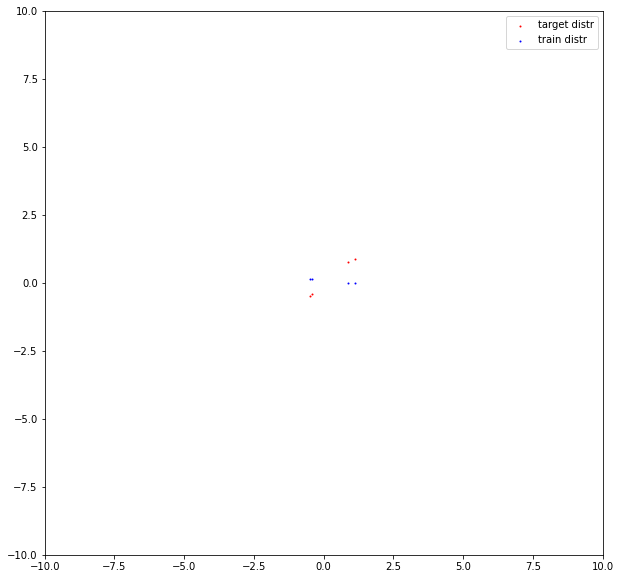

In [46]:
plt.figure(figsize=(10, 10))
plot_2d_dots(torch.cat((x_train, y_train.unsqueeze(1)), 1), color='r', label='target distr')
plot_2d_dots(torch.cat((x_train, y_pred.detach()), 1), color='b', label='train distr')
plt.legend()
plt.show()